In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm


## Part 1: Parsing the NYTimes Quotes 

In [2]:
def process_data(chunk):
    vals = chunk['urls'].values
    bool_val = []
    # Keep only the entries in the dataframe that come from nytime.com articles
    for element in vals:
        bool_val.append(np.any(np.array(list(map(lambda x: "nytimes" in x, element)))))
    # Now we have a new df with only quotations from nytimes.com urls 
    ny_times_df = chunk[bool_val].drop(['quoteID','speaker','qids','date','numOccurrences','probas','phase'],axis=1)
    # Parse the topic from the url
    list_parsed = []
    first_level_topic = []
    second_level_topic = []
    for urls in ny_times_df['urls'].values:    
        first_level_set = set()
        second_level_set = set()
        for url in urls:
            first_level_tmp = re.findall('nytimes.com/[reuters/|aponline/|interactive/]*[0-9]{4}/[0-9]{2}/[0-9]{2}/(\w+)/', url)
            second_level_tmp = re.findall('nytimes.com/[reuters/|aponline/|interactive/]*[0-9]{4}/[0-9]{2}/[0-9]{2}/\w+/(\w+)/', url)
            if len(first_level_tmp) > 0:
                first_level_set.update(first_level_tmp)
                if len(second_level_tmp)>0:
                    second_level_set.update(second_level_tmp)
                else:
                    second_level_set.update(first_level_tmp)
        first_level_topic.append(list(first_level_set))
        second_level_topic.append(list(second_level_set))
    if not (len(ny_times_df['urls'].values)==len(first_level_topic) and len(ny_times_df['urls'].values)==len(second_level_topic)):
        return None
        print("Problem with length")
    ny_times_df['level1_topic'] = [(topics[0] if len(topics)>0 else np.nan) for topics in first_level_topic]
    ny_times_df['level2_topic'] = [(topics[0] if len(topics)>0 else np.nan) for topics in second_level_topic]
    return ny_times_df

In [3]:

# Read the blocks of 100000 quotations and store them in a dataframe
with pd.read_json('Quotebank/quotes-2019.json.bz2', lines=True, compression='bz2', chunksize=100000) as df_reader:
    i = 0
    for chunk in df_reader:
        print(f"Processing Chunk: {i}")
        ny_times_df = process_data(chunk)
        counts_series_lvl1 = ny_times_df["level1_topic"].value_counts(dropna=True)
        counts_series_lvl2 = ny_times_df["level2_topic"].value_counts(dropna=True)
        # First write to the csv file
        if i == 0:
            ny_times_df.to_csv('ny_times_2019.csv')
            count_lvl1_df = pd.DataFrame({'topic':counts_series_lvl1.index, 'count':counts_series_lvl1}).reset_index(drop=True)
            count_lvl2_df = pd.DataFrame({'topic':counts_series_lvl2.index, 'count':counts_series_lvl2}).reset_index(drop=True)
        else:
            ny_times_df.to_csv('ny_times_2019.csv', mode='a', header=False)
            temp_lvl1_df = pd.DataFrame({'topic':counts_series_lvl1.index, 'count':counts_series_lvl1}).reset_index(drop=True)
            temp_lvl2_df = pd.DataFrame({'topic':counts_series_lvl2.index, 'count':counts_series_lvl2}).reset_index(drop=True)
            count_lvl1_df = pd.concat([count_lvl1_df, temp_lvl1_df]).groupby(['topic']).sum().reset_index().sort_values(by=['count'], ascending=False)
            count_lvl2_df = pd.concat([count_lvl2_df, temp_lvl2_df]).groupby(['topic']).sum().reset_index().sort_values(by=['count'], ascending=False)
        i += 1

ny_times_df.head(20)

Processing Chunk: 0
Processing Chunk: 1
Processing Chunk: 2
Processing Chunk: 3
Processing Chunk: 4
Processing Chunk: 5
Processing Chunk: 6
Processing Chunk: 7
Processing Chunk: 8
Processing Chunk: 9
Processing Chunk: 10
Processing Chunk: 11
Processing Chunk: 12
Processing Chunk: 13
Processing Chunk: 14
Processing Chunk: 15
Processing Chunk: 16
Processing Chunk: 17
Processing Chunk: 18
Processing Chunk: 19
Processing Chunk: 20
Processing Chunk: 21
Processing Chunk: 22
Processing Chunk: 23
Processing Chunk: 24
Processing Chunk: 25
Processing Chunk: 26
Processing Chunk: 27
Processing Chunk: 28
Processing Chunk: 29
Processing Chunk: 30
Processing Chunk: 31
Processing Chunk: 32
Processing Chunk: 33
Processing Chunk: 34
Processing Chunk: 35
Processing Chunk: 36
Processing Chunk: 37
Processing Chunk: 38
Processing Chunk: 39
Processing Chunk: 40
Processing Chunk: 41
Processing Chunk: 42
Processing Chunk: 43
Processing Chunk: 44
Processing Chunk: 45
Processing Chunk: 46
Processing Chunk: 47
Pr

,quotation,urls,level1_topic,level2_topic
21700307,Jackson Pollock said that each new age demands...,[https://www.nytimes.com/2019/03/07/obituaries...,obituaries,obituaries
21700486,"Like the Sasquatch from the commercial,",[http://www.nytimes.com/2019/01/28/sports/bask...,sports,basketball
21700523,looking for a woman of incredibly poor judgment.,[https://www.nytimes.com/2019/09/24/style/tiny...,style,style
21700556,Machines and computers are great at counting t...,[https://www.nytimes.com/2019/05/20/fashion/da...,fashion,fashion
21700592,many of the best known and most important Fren...,[http://www.nytimes.com/2019/02/26/fashion/mee...,fashion,fashion
21700625,Maybe we can get to a point where the entry of...,[http://nytimes.com/interactive/2019/04/27/ups...,upshot,upshot
21700767,My childhood was spent in the zoo. We would pi...,[https://www.nytimes.com/interactive/2019/04/1...,arts,design
21700863,near-simultaneous publication of an accompanyi...,[http://mobile.nytimes.com/2019/06/06/opinion/...,opinion,opinion
21700924,"No one's jaw dropped yesterday,",[http://www.nytimes.com/2019/03/01/world/middl...,world,middleeast
21701123,Once in a while when they would get a decent c...,[http://www.nytimes.com/2019/10/18/sports/base...,sports,baseball


In [4]:
count_lvl1_df

,topic,count
34,us,43319
38,world,23917
0,arts,22619
27,sports,19088
5,business,13565
21,opinion,13270
2,books,10093
19,nyregion,9900
28,style,6679
16,magazine,6265


<AxesSubplot:xlabel='count', ylabel='topic'>

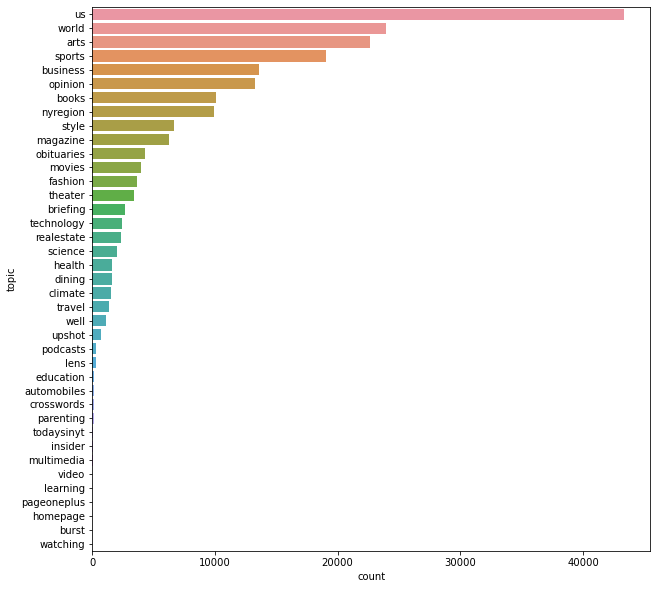

In [22]:
plt.figure(figsize=(10, 10))
sns.barplot(data=count_lvl1_df, x="count", y="topic")

In [5]:
count_lvl2_df.head(50)

,topic,count
68,politics,29223
89,us,13993
79,sports,10581
63,opinion,10043
32,europe,9656
60,nyregion,9451
13,business,7438
80,style,6695
83,television,6650
48,magazine,6270


<AxesSubplot:xlabel='count', ylabel='topic'>

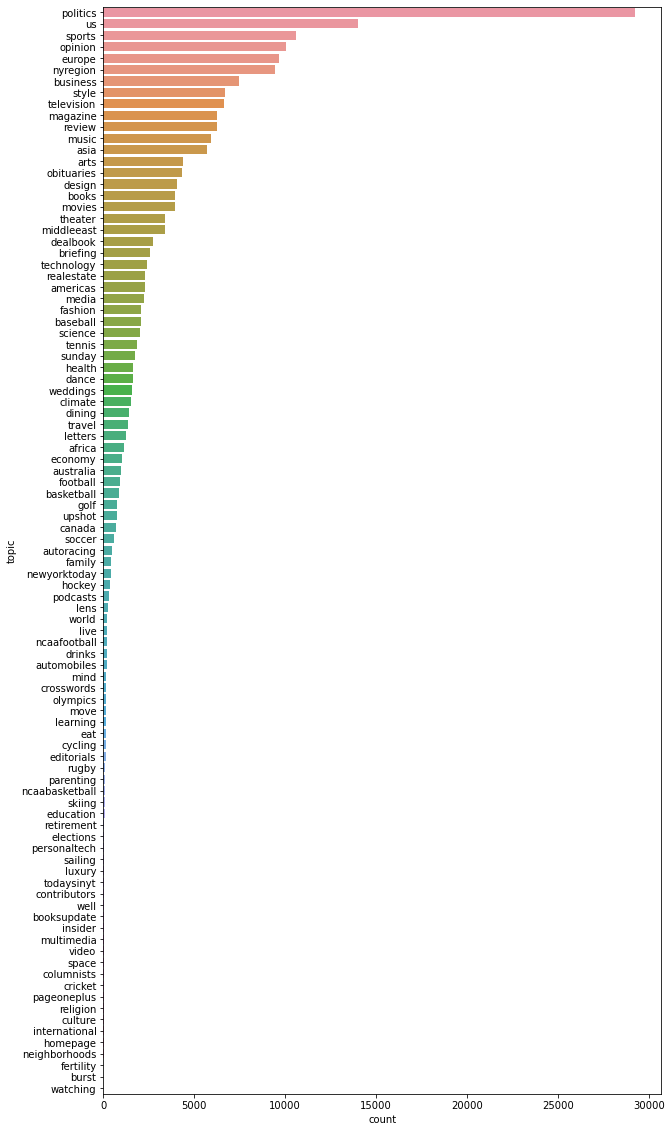

In [26]:
plt.figure(figsize=(10, 20))
sns.barplot(data=count_lvl2_df, x="count", y="topic")

## Part 2: Modify the parsed Topics & Quotes

We may only be interested in certain topics. For instance, we may just want the following topics: 
* **sports** (includes all sports in the more specific dataframe)
* **politics** (retrieved from the more specific dataframe)
* **arts** (includes television, music, etc. - we may want to add movies and books in this section)
* **europe** (taken from more specific dataframe)
* **asia** (taken from more specific dataframe)
* **middleeast** (taken from more specific dataframe)
* **us** (taken from more specific dataframe)
* **technology** (taken from first less specific dataframe)
* **science** (taken from first less specific dataframe)
* **climate** (taken from first less specific dataframe)
* **style & fashion** (mixed from first less specific dataframe)


In [76]:
PATH_TOPIC = "NYtimes/Topics/ny_times"

# Method to process the chunk given into 4 dataframes for each of the four topics chosen. 
def process_topics(chunk, flag_first):
    sports_df = chunk[chunk['level1_topic']=="sports"]
    technology_df = chunk[chunk['level1_topic']=="technology"]
    politics_df = chunk[chunk['level2_topic']=="politics"]
    climate_df = chunk[chunk['level2_topic']=="climate"]
    if flag_first:
        sports_df.to_csv(PATH_TOPIC+'_sports.csv', index=False)
        technology_df.to_csv(PATH_TOPIC+'_technology.csv', index=False)
        politics_df.to_csv(PATH_TOPIC+'_politics.csv', index=False)
        climate_df.to_csv(PATH_TOPIC+'_climate.csv', index=False)
    else:
        sports_df.to_csv(PATH_TOPIC+'_sports.csv', mode='a', header=False, index=False)
        technology_df.to_csv(PATH_TOPIC+'_technology.csv', mode='a', header=False, index=False)
        politics_df.to_csv(PATH_TOPIC+'_politics.csv', mode='a', header=False, index=False)
        climate_df.to_csv(PATH_TOPIC+'_climate.csv', mode='a', header=False, index=False)
    

In [77]:
dates=["2015","2016","2017","2018","2019","2020"]
# Read the blocks of 100000 quotations and store them in a dataframe
flag_first = True
for date in dates:
    print(f"Processing Date: {date}")
    with pd.read_csv(f'NYtimes/ny_times_{date}.zip', compression='zip', chunksize=10000) as df_reader:
        i = 0
        for chunk in df_reader:
            chunk["year"] = [date]*chunk.shape[0]
            print(f"Processing Chunk: {i}")
            process_topics(chunk, flag_first)
            flag_first = False
            i += 1
        



Processing Date: 2015
Processing Chunk: 0
Processing Chunk: 1
Processing Date: 2016
Processing Chunk: 0
Processing Chunk: 1
Processing Chunk: 2
Processing Chunk: 3
Processing Chunk: 4
Processing Chunk: 5
Processing Chunk: 6
Processing Chunk: 7
Processing Chunk: 8
Processing Chunk: 9
Processing Chunk: 10
Processing Chunk: 11
Processing Chunk: 12
Processing Chunk: 13
Processing Chunk: 14
Processing Chunk: 15
Processing Chunk: 16
Processing Date: 2017
Processing Chunk: 0
Processing Chunk: 1
Processing Chunk: 2
Processing Chunk: 3
Processing Chunk: 4
Processing Chunk: 5
Processing Chunk: 6
Processing Chunk: 7
Processing Chunk: 8
Processing Chunk: 9
Processing Chunk: 10
Processing Chunk: 11
Processing Chunk: 12
Processing Chunk: 13
Processing Chunk: 14
Processing Chunk: 15
Processing Chunk: 16
Processing Chunk: 17
Processing Chunk: 18
Processing Chunk: 19
Processing Chunk: 20
Processing Chunk: 21
Processing Chunk: 22
Processing Chunk: 23
Processing Chunk: 24
Processing Date: 2018
Processing

## Part 3: Build the final Data Set 
We note that we want to give more or less identical number of quotes from random years for each topics. Thus we do a bit of parsing to make sure that we have a balanced training data set between the topics

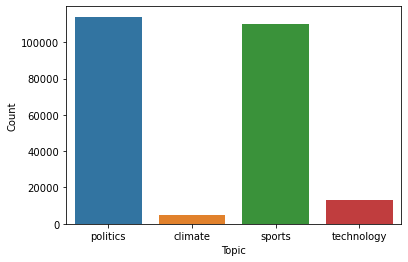

In [79]:
# First we check the number of quotes per topic that we retrieved
PATH="NYTimes/Topics/ny_times_"
topics = ["politics", "climate", "sports", "technology"]
count_df = pd.DataFrame({"Topic":[], "Count":[]})
for topic in topics: 
    df = pd.read_csv(PATH+topic+".zip", compression='zip')
    count_df.loc[len(count_df.index)] = [topic, df.shape[0]]

sns.barplot(data=count_df, x="Topic", y="Count");

As we can see there is a huge distribution disproportion between the retrieved topics. Climate has only about 5000 topics whereas Politics and Sports have over 100,000. This needs to be taken into account when building the training set for the topic modelling. Therefore we will create a training set of about 20,000 quotations: 5000 for each topic. 

In [12]:
# Load the four dataframes
sports_df = pd.read_csv("NYTimes/Topics/ny_times_sports.zip", compression='zip')
politics_df = pd.read_csv("NYTimes/Topics/ny_times_politics.zip", compression='zip')
technology_df = pd.read_csv("NYTimes/Topics/ny_times_technology.zip", compression='zip')
climate_df = pd.read_csv("NYTimes/Topics/ny_times_climate.zip", compression='zip')

In [13]:
sports_df_shuffled = sports_df.sample(frac=1)
politics_df_shuffled = politics_df.sample(frac=1)
technology_df_shuffled = technology_df.sample(frac=1)
climate_df_shuffled = climate_df.sample(frac=1)

final_training_df = pd.concat([sports_df_shuffled.head(5000), politics_df_shuffled.head(5000),
                               technology_df_shuffled.head(5000),climate_df_shuffled],ignore_index=True)
# Shuffle one last time
final_training_df = final_training_df.sample(frac=1)
cols = [0, 1]
final_training_df.drop(final_training_df.columns[cols], axis=1, inplace=True)
final_training_df.head()

,quotation,urls,level1_topic,level2_topic,year
1469,The public is certainly siding with McGregor b...,['https://www.nytimes.com/2017/07/25/sports/co...,sports,sports,2017
9422,I cannot fathom why the Administration would p...,['http://www.foxnews.com/politics/2017/03/21/t...,us,politics,2017
8590,We will continue developing ballistic missile-...,['https://www.nytimes.com/2017/08/30/us/politi...,us,politics,2017
325,Hey Lee / Your short game's good / but your lo...,['http://www.nytimes.com/2016/09/27/sports/gol...,sports,golf,2016
773,"There are many, many people who invest and par...",['http://www.nytimes.com/2019/06/15/sports/aut...,sports,autoracing,2019


In [15]:
# Save the final training file to csv
final_training_df.to_csv("NYTimes_topic_modeling_training.csv",index=False)